<a href="https://colab.research.google.com/github/zurkin1/Machine-Learning/blob/master/Ex3_Deep_Learning_for_Machine_Perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><b>Deep Learning for Machine Perception</b></center></h1>
<h3><center>Exercise 3</center></h3>

Your Names:  
<font color='red'>
FirstName1 LastName1, 123456789  
FirstName2 LastName2, 987654321  
</font>


____________

In this exercise we will:
1. Understand how object detection models work and specifically how Faster RCNN  works.
2. Evaluate a pretrained object detection model.
3. Fine-tune object detection model on a custom dataset.

**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Make sure you don't leave empty cells or empty answers.
- You should not change the code that we have provided to you.
- When you finish the assignment, download the *notebook* and submit it to the [**"submit"**](https://submit.cs.biu.ac.il/cgi-bin/welcome.cgi) system. 
To Download the notebook go to **"File"** -> **"Download .ipynb"**.  
- For questions regarding the assignment send a mail to: ‫biu.cs.896874@gmail.com‬  

### **1. Setup**
Before running code on Colab:
- Go to "Runtime" -> "Change runtime type", and make sure to choose "GPU" for Hardware accelerator.
- Check your Python version at the command line by running "!python --version". It should be Python 3.6 by default.

In [ ]:
# check python version
!python --version

### **2. Faster-RCNN**

In this exercise, we are going to use a pretrained Faster-RCNN object detector model.

Before starting this assignment, let's first understand how Faster RCNN works.  






**Faster RCNN** is an object detection architecture presented by Ross Girshick, Shaoqing Ren, Kaiming He and Jian Sun ([https://arxiv.org/abs/1506.01497](https://arxiv.org/abs/1506.01497)). It is one of the famous object detection architectures that uses a convolution neural network.

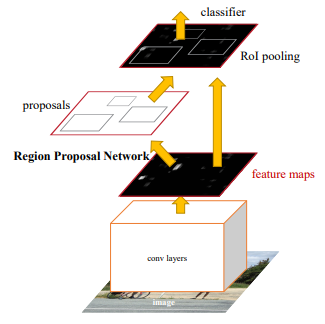

In short, Faster RCNN is composed of 3 neural networks:  
1. **Feature Network** - The feature network is usually a pretrained image classification network (convolutional neural network) model (like VGG or ResNet) without the top layers (the classification layers). The goal of this network is to generate features from the given images. The output of this network maintains the shape and structure of the original image ( i.e. still rectangular, pixels in the original image roughly gets mapped to corresponding feature “pixels”, etc.)
2. **Region Proposal Network** (RPN) - The region proposal network is a simple network with 3 convolutional layers. The first layer gets the features from the *Feature Network* and its output is fed into the left two layers: one layer for classification and the other for bounding box regression. The goal of RPN is to generate a number of bounding boxes called Region of Interests (ROIs) that have high probability of containing any object. The output from this network is a number of bounding boxes identified by the pixel co-ordinates of two diagonal corners, and a value (1, 0, or -1, indicating whether an object is in the bounding box or not or the box can be ignored respectively ).
3. **Detection Network** - The Detection Network takes input from both the *Feature Network* and *RPN*, and generates the final classes and bounding boxes. It is normally composed of 4 Fully Connected or Dense layers. There are 2 stacked common layers shared by a classification layer and a bounding box regression layer. To help it classify only the inside of the bounding boxes, the features are cropped according to the bounding boxes.


It is important to understand the input and output of a Faster RCNN model:

**Input:**  
- ***Input image*** tensor to be in the form [n, c, h, w] and min size of 800px, where:  
n is the number of images,  
c is the number of channels (for RGB images it's 3),  
h is the height of the image,  
w is the width of the image.

**Outputs:**  
- ***Bounding boxes*** - bounding boxes ([x0,x1,y0,y1]) for each proposal.
- ***Labels*** - class labels for each box (should be between 0 and 90).
- ***Scores*** - confidence scores for each box (should be between 0 to 1). The probability that a box contains an object. 

__________

Now that we understand how Faster RCNN works, let's use a pretrained one, that was trained on the COCO dataset.

**[COCO dataset](https://cocodataset.org/)** - COCO is a large-scale object detection, segmentation, and captioning dataset. It contains more than 200,000 images and 80 object categories.

Let's first define all the classes a pretrained networks can detect:

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
print("#Classes with N/A:", len(COCO_INSTANCE_CATEGORY_NAMES))
print("#Classes without N/A", len(list(filter(lambda x: x!="N/A", COCO_INSTANCE_CATEGORY_NAMES))))

You can see that there are 91 categories: 80 objects, 1 background and 10 "N/A"s.  

The model outputs predictions for all categories, but since those N/A classes were removed in later papers, we ignore them and only keep them as placeholders.

To use a pretrained model, we can use the **torchvision** package: The package consists of popular datasets, model architectures, and common image transformations for computer vision. It has a lot of powerful pretrained models we can employ with few lines of code.  Full documentation can be found [here](https://pytorch.org/docs/stable/torchvision/index.html).

We will create an instance of a Faster RCNN model with ResNet-50 as its backbone. Setting ```pretrained=True```, downloads the pretrained weights and assigns them to the model.

In [ ]:
import torchvision 
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# load a Faster RCNN model pre-trained on COCO 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

We want to test our model on real-world images and see that it works.  
To do that, we are going to use two new packages: PIL and cv2.  

**PIL** is a Python Imaging Library (abbreviated as PIL). It is a free and open-source additional library for the Python programming language that adds support for opening, manipulating, and saving many different image file formats.

**cv2 (OpenCV)** is a library of programming functions mainly aimed at real-time computer vision. The library has more than 2500 optimized algorithms, which includes a comprehensive set of both classic and state-of-the-art computer vision and machine learning algorithms.


Those packages will help us load, draw bounding boxes and write texts on images.

Take a look at the ```load_image``` function below:

In [ ]:
def load_image(img_path):
  """
  The function uses PIL.Image to load image from image_path.
  It transforms the image into a tensor and returns it.
  """
  # PIL.Image loads a image from a given path.
  # The result value is a numpy array
  img = Image.open(img_path)
  # Using pytorch 'transforms' we convert it to a tensor
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img) # Apply the transform to the image
  return img

We can now implement the function ```make_prediction``` which is the general template for making a single prediction.  
We have implemented it for you:

In [ ]:
def make_prediction(model, img_path, device="cuda"):
  """
  The function load the image from image_path,
  move image and model to the device (gpu or cpu) 
  and do a forward pass (inference) using the given model
  """
  # model to device
  model = model.to(device)
  # load image
  img = load_image(img_path)
  # image to device
  img = img.to(device)
  # make a prediciton
  pred = model([img])
  return pred

Let's see that everything works as expected. We first download an image using the command below. You should see a jpg file in the Files Browser.

In [ ]:
# a linux command to download images
!wget https://images.unsplash.com/photo-1534567153574-2b12153a87f0 -O zoo.jpg

We can plot the image using cv2 and matplotlib:

In [ ]:
# re-load image with cv2 
img = cv2.imread("zoo.jpg")
# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# show image
plt.figure(figsize=(20,30))
plt.imshow(img)
plt.show()

Now we can make a prediction using the code implemented above:

In [ ]:
# first set model to eval mode (always before inference)
model.eval()
# call ```make_prediction```
preds = make_prediction(model,img_path="zoo.jpg", device="cuda")[0]
# print preds
print(preds)

The model outputs a dictionary with three tensors: **boxes**, **labels** and **scores** (as said before).

***Ungraded question:***  
**Q:** We used above```device=cuda``` to make inference on the GPU. Change it to ```device=cpu```. What is the time difference between the two approaches?

**A**: 
<font color='red'>
YOUR ANSWER HERE!  
</font>

Let's plot the bounding boxes using the following function:

In [ ]:
def plot_predictions(image_path, boxes, pred_cls=None, box_thickness=8, txt_size=3, txt_thickness=3):
    """
    The function load image from image_path using cv2 and draw bounding boxes (```boxes```)
    and classes (```pred_cls```) [if given] near each bounding box.
    """
    # re-load image with cv2 
    img = cv2.imread(image_path)
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot boxes
    for i in range(len(boxes)):
      cv2.rectangle(img, (boxes[i][0],boxes[i][1]), (boxes[i][2],boxes[i][3]),color=(0, 255, 0), thickness=box_thickness) # Draw Rectangle with the coordinates
      if pred_cls is not None:
        # plot labels if given
        cv2.putText(img,pred_cls[i], (boxes[i][0],boxes[i][1]),  cv2.FONT_HERSHEY_SIMPLEX, txt_size, (0,255,0),thickness=txt_thickness) # Write the prediction class
    # show image
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.show()

In [ ]:
# takes ```preds``` from above, extract its boxes and plot them
plot_predictions("zoo.jpg", preds["boxes"].detach().cpu().numpy())

As you can see the model performs well and detect all objects in the image.  

However, it is not perfect. Some boxes were plotted without any particular objects in them (False Positives).  
Those boxes have usually lower *confidence scores* (which a model outputs as well).

Implement the function below, which takes all bounding boxes, all labels and all scores and filters those with a confidence score lower than the given threshold.  
The function should return two arrays:  
1. ```pred_boxes``` - bounding boxes with score > threshold.
2. ```pred_class``` - corresponding  labels.  
--> Make sure they have the same length.

In [ ]:
def filter_predictions(raw_preds, threshold):
    """
    The function gets ```raw_preds``` - a dictionary with all model predictions
    (boxes, labels and confidence scores) and filter those with score < threshold.
    It returns pred_boxes (the remaining bounding boxes) and pred_class
    (the corresponding remaining labels).
    """
    # get all bounding boxes
    raw_bounding_boxes = raw_preds['boxes'].detach().cpu().numpy()
    # get all labels
    raw_labels = raw_preds['labels'].detach().cpu().numpy()
    # get confidence scores for each box.
    pred_score = raw_preds['scores'].detach().cpu().numpy()
    ######################
    ### YOUR CODE HERE ###
    ######################
    # pred_boxes = ...
    # pred_class = ...
    ######################
    return pred_boxes, pred_class

To make it easier for us, let's create a pipeline function which is a template for everything we need to do for inference:

In [ ]:
def detection_inference(model, image_path, threshold, box_thickness=8, txt_size=3, txt_thickness=3):
  """
  A template function for detection inference:
  1. Load image from ```image_path```
  2. Forward pass to get raw predictions
  3. Filter predictions with confidence scores lower than ```threshold```
  4. Plot image with bounding boxes and labels.
  """
  # first set model to eval mode (always before inference)
  model.eval()
  # make a prediction
  raw_preds = make_prediction(model,image_path, device="cuda")[0]
  # filter predictions by confidence scores
  pred_boxes, pred_class = filter_predictions(raw_preds, threshold=threshold)
  # plot bounding boxes with labels
  plot_predictions(image_path, pred_boxes, pred_class, box_thickness, txt_size, txt_thickness)

In [ ]:
# call detection inference above with threshold=50%
detection_inference(model, "zoo.jpg", threshold=0.5, box_thickness=8, txt_size=3, txt_thickness=5)

If you implemented everything correctly, you should see a bounding box for each animal and its label near the bounding box (without redundant boxes!). 

**Your turn:** Follow the steps above, download an image from the internet and check the model performance on it. Adjust the ```threshold``` as well for better results.

In [ ]:
!wget ???

In [ ]:
######################
### YOUR CODE HERE ###
######################

### **3. Evaluating Object Detection Models**

So we have an object detection model that, visually, seems to work well. We, humans, are expert object detectors, and we can say that these detections are correct, but how do we quantify this?  
Like every model in machine learning we would like to evaluate it. We want to see how good it is on test data and even compare it to other models.

In this section, we are going to implement an evaluation function for an object detection model. We will calculate the **Mean Average Precision** for a given image and plot the **Precision-Recall Curve**. 

Go over this **[great article](https://manalelaidouni.github.io/manalelaidouni.github.io/Evaluating-Object-Detection-Models-Guide-to-Performance-Metrics.html)** to understand how to evaluate an object detection model: What are **IOU**, **Precision**, **Recall**, **Average Precision** and **Mean Averge Precision**.

Before diving into MAP, let's implement some basic functions first.  



<font color='warning'><b>
In this section, you are not allowed to use any packages except Numpy!!
</b></font>

##### **3.1 Intersection Over Union**

We start with the calculation of **Intersection Over Union (IOU)** between a predicted bounding box and a ground truth bounding box.

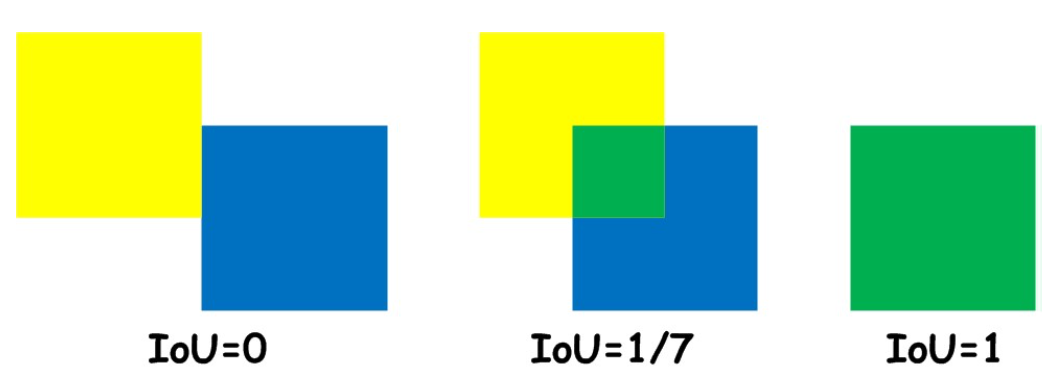

Implement the function ```intersection_over_union``` below.

In [ ]:
import numpy as np

In [ ]:
def intersection_over_union(pred_bb, gt_bb):
    """
    The function calculates the IOU between the ground truth (gt_bb)
    and the predicted bouning box (pred_bb).
    Note:
    bbox = [x_top-left, y_top-left, x_bottom-right, y_bottom-right]
    where (0, 0) is at the top left and the positive Y-axis goes in the
    downwards direction of the image.
    """
    ######################
    ### YOUR CODE HERE ###
    ######################
    # iou_value = ...
    ######################
    return iou_value

You can check your implementation with the toy example below.  
**Note: The grader will run your implementation on more complicated examples. Points will be deducted for incorrect outputs. Check your implementation carefully before submission.**

In [ ]:
intersection_over_union([39, 63, 203, 112], [54, 66, 198, 114])

If your implementation is correct the result should be 0.798.

##### **3.2 Precision and Recall**

Let's also implement precision and recall. Implement the code below.

In [ ]:
def precision_and_recall(image_res):
    """
    The function gets a dictionary containing TP (True Positive),
    FP (False Positive) and FN (False Negative) values of a single image(!).
    It returns a tuple: (Precision, Recall)
    Calculates precision and recall from the set of images
    """
    tp = image_res['true_positive']
    fp = image_res['false_positive']
    fn = image_res['false_negative']
    ######################
    ### YOUR CODE HERE ###
    ######################
    # precision = ...
    # recall = ...
    ######################
    return (precision, recall)

In [ ]:
precision_and_recall({'true_positive': 2, 'false_positive': 11, 'false_negative': 0})

##### **3.3 True Positive, False Positive and False Negative**

Now we can work on the interesting part of the evaluation. :)  
Implement the function ```calculate_scores``` which gets *predictions*, *ground truths* and *threshold for IOU* and returns *TP*, *FP* and *FN*.   

The article that we mentioned before should help you with the implementation (i.e. how to calculate TP, FP and FN).  
Few things to remember \ hints:
- Go over each ground truth and find the best prediction (the one with the highest iou with the ground truth)
- Make sure you do not choose the same prediction more than once (match one ground truth to one prediction). Once prediction is matched, it can't be matched to another ground truth.

In [ ]:
def calculate_scores(pred_bbs, gt_bbs, iou_threshold=0.5):
    """
    The function calculates True Positives, False Positives and False Negatives
    scores for the given prediction boxes (pred_bbs), ground truth boxes (gt_bbs)
    and iou_threshold.
    It returns a dictionary: {'true_positive': TP, 'false_positive': FP, 'false_negative': FN}
    """
    TP = 0
    FP = 0
    FN = 0
    ######################
    ### YOUR CODE HERE ###
    ######################
    return {'true_positive': TP, 'false_positive': FP, 'false_negative': FN}

You can check your implementation with the toy example below.  
**Note: The grader will run your implementation on more complicated examples. Points will be deducted for incorrect outputs. Check your implementation carefully before submission.**

In [ ]:
calculate_scores([[335, 468, 392, 510], [361, 461, 396, 526], [425, 438, 456, 503],
                  [333, 470, 408, 545], [485, 482, 513, 527], [362, 465, 422, 542],
                  [349, 464, 394, 498], [490, 464, 508, 516], [341, 468, 367, 501],
                  [473, 440, 525, 526], [362, 463, 387, 490], [654, 484, 675, 536],
                  [489, 460, 519, 524], [646, 444, 675, 537]],
                 [[485, 462, 520, 534], [642, 440, 681, 541],[0,0,0,0]])

If your implementation is correct the result should be ```{'false_negative': 1, 'false_positive': 12, 'true_positive': 2}```.

**Q1:** What should be the scores (TP, FP, FN) when the ```gt_bbs``` is empty (i.e no objects in the given image)? Why?  
(Don't forget to address this in your implementation.)

**A1**: 
<font color='red'>
YOUR ANSWER HERE!  
</font>

**Q2:** What should be the scores (TP, FP, FN) when the ```pred_bbs``` is empty (i.e the model doesn't detect any object)? Why?  
(Don't forget to address this in your implementation.)

**A2**: 
<font color='red'>
YOUR ANSWER HERE!  
</font>

**Q3:** What should be the scores (TP, FP, FN) when the prediction after thresholding (after removing predictions with IOU < threshold) is empty? Why?  
(Don't forget to address this in your implementation.)

**A3**: 
<font color='red'>
YOUR ANSWER HERE!  
</font>

##### **3.4 Precision - Recall Curve**

We can now combine everything and plot the Precision-Recall Curve.   
***Reminder:*** In object detection, the model outputs for each bounding box a confidence value (this is how confident the detector is in its prediction).  
To plot the Precision-Recall Curve we can sort the confidence scores and at each confidence threshold. Then we can measure the precision and recall of the detector, giving us one data point.

In [ ]:
def precision_recall_curve(pred_bbs, confidence_scores, gt_bbs):
  """
  The function gets predictions for bound boxes (pred_bbs), confidence score for 
  each bounding box (confidence_scores) and groud truth (gt_bbs).
  It returns two lists of integers: 
  list1 - list of precision values at each threshold
  list2 - list of recall values at each threshold
  """
  # create empty lists for (precision, recall) for each threshold
  precision_ls = []
  recall_ls = []

  # first sort confidence_scores
  sorted_thresholds = sorted(confidence_scores)
  # loop through sorted_confidence_scores  
  for current_threshold in sorted_thresholds:
    # filter predictions with confidence lower than current threshold
    remaining_preds_idx = []
    for idx, pred_conf_score in enumerate(confidence_scores):
      if pred_conf_score >= current_threshold:
        remaining_preds_idx.append(idx)
    # keep preds with high enough confidence values
    remaining_preds = np.array(pred_bbs)[remaining_preds_idx]
    # call ```calculate_scores``` to get TP, FP and FN
    performance_scores = calculate_scores(remaining_preds, gt_bbs)
    # call ```precision_and_recall``` to get precision and recall
    precision, recall = precision_and_recall(performance_scores)
    # append to final lists
    precision_ls.append(precision)
    recall_ls.append(recall)
  return precision_ls, recall_ls


Let's take the toy example below to plot the curve.

In [ ]:
precision_ls, recall_ls = precision_recall_curve(
    [[330, 463, 387, 505], [356, 456, 391, 521], [420, 433, 451, 498], [328, 465, 403, 540],
     [480, 477, 508, 522], [357, 460, 417, 537], [344, 459, 389, 493], [485, 459, 503, 511],
     [336, 463, 362, 496], [468, 435, 520, 521], [357, 458, 382, 485], [649, 479, 670, 531],
     [484, 455, 514, 519], [641, 439, 670, 532]],
     [0.0739, 0.0843, 0.091, 0.1008, 0.1012, 0.1058, 0.1243,
      0.1266, 0.1342, 0.1618, 0.9452, 0.9505, 0.9113, 0.972],
     [[480, 457, 515, 529], [637, 435, 676, 536], [643, 473, 675, 536]]
)

In [ ]:
# plot precision/recall curve
import matplotlib.pyplot as plt

plt.plot(recall_ls,precision_ls)
plt.ylabel("Precision")
plt.xlabel("Recall")

##### **3.5 Mean Average Precision**

The last thing left to do is to calculate the Mean Average Precision. We are going to implement it using the common **11 point interpolation technique**:

$$mAP = \frac{1}{11}\sum_{Recall_i}{Precision(Recall_i)} $$

The idea is simple:  
Go over 11 recall values $[0,0.1,0.2,...,1.0]$ and for each value check $Precision(Recall_i)$. Than average all values.  

$Precision(Recall_i)$ = The maximum precision measured at a recall exceeding $Recall_i$.  

For example:  
Given a list of precisions and list of recalls from a Precision-Recall Curve:

| Recall          | Precision      | 
| :-------------  | :-------------:| 
|       0.20      |      1.00      | 
|       0.20      |      0.50      | 
|       0.40      |      0.40      | 
|       0.40      |      0.67      | 
|       0.60      |      0.50      | 
|       0.60      |      0.50      | 
|       0.80      |      0.57      | 
|       0.80      |      0.44      | 
|       1.00      |      0.50      | 
|       1.00      |      0.47      | 


We can calculate the Mean Average Precision by:

| Recall  Values  | Precision(Recall_i)| 
| :-------------  | :----------------: | 
|       0.00      |        1.00        | 
|       0.10      |        1.00        | 
|       0.20      |        1.00        | 
|       0.30      |        0.67        | 
|       0.40      |        0.67        | 
|       0.50      |        0.57        | 
|       0.60      |        0.57        | 
|       0.70      |        0.57        | 
|       0.80      |        0.57        | 
|       0.90      |        0.50        |
|       1.00      |        0.50        | 


$$mAP = \frac{1}{11}\sum_{Recall_i}{Precision(Recall_i)}  
= \frac{1}{11}*(1.00+1.00+1.00+0.67+0.67+0.57+0.57+0.57+0.57+0.50+0.50) = \textbf{0.69}$$

Implement the function ```mean_avg_precision``` below.

In [ ]:
def mean_avg_precision(precision_ls, recall_ls):
  """
  The function takes a list of precisions and list of recalls from
  a Precision-Recall Curve and returns the Mean Average Precision.
  """
  recall_i = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]  
  ######################
  ### YOUR CODE HERE ###
  ######################
  # map = ...
  ######################
  return map

In [ ]:
# check your implementation with:
# A - dummy example
r = [0.20,0.20,0.40,0.40,0.60,0.60,0.80,0.80,1.00,1.00]
p = [1.00,0.50,0.40,0.67,0.50,0.50,0.57,0.44,0.50,0.47]
print("A. Mean Average Precision:", mean_avg_precision(p, r))
# B - precision-recall curve from previous sub-section
print("B. Mean Average Precision:", mean_avg_precision(precision_ls, recall_ls))

If your implementation is correct the result should be ```0.692``` for A and ```0.909``` for B.

### **4. Finetuning**

In this section, we will be finetuning the pretrained Faster RCNN on another dataset called **Penn-Fudan**.  
We will be using the same dataset as in this [PyTorch Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).  
During this section, you can use this tutorial as a reference, but notice that here, you should finetune a Faster RCNN model (which predicts boxes, labels and scores) and not Mask RCNN (which also do object segmentation).

In [ ]:
%%shell

# Downloding dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

# Download helper functions for the training
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from engine import train_one_epoch, evaluate
import utils
import transforms as T

As always, let's visualize the data. We can use the PIL package to do that:

In [ ]:
# loading and plotting random image (you can change the image name to see other images)
Image.open('PennFudanPed/PNGImages/FudanPed00028.png')

In pytorch, we need to create a ```Dataset``` object when using custom datasets (like Penn Fudan). We have implemented it(using the tutorial) for you:

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

**Now take it from here:** (1) create dataloaders for the train set and validation set (you can use transformations as well), (2) create a pretrained Faster RCNN model and replace the weights of the head with random ones (important step before finetuning), create optimizer and lr_scheulder, and eventually train the model for 10 epochs.  

You are encouraged to use the helper functions ```train_one_epoch``` and ```evaluate``` from the ```engine``` module.

**Do not forget to train the model on the gpu (otherwise it might take hours)**

In [ ]:
######################
### YOUR CODE HERE ###
######################
# you can spread your code between multiple cells.

**Q:** After 10 epochs, what is the Mean Average Precision on the validation data?

**A:**
<font color='red'>
YOUR ANSWER HERE!  
</font>

Now that we have a fine-tuned model, let's visually see its performance on the test data:

In [ ]:
# call detection inference above with threshold=50%
detection_inference(model, 'PennFudanPed/PNGImages/FudanPed00012.png', threshold=0.5, box_thickness=2, txt_size=0.8, txt_thickness=2)

In [ ]:
# call detection inference above with threshold=50%
detection_inference(model, 'PennFudanPed/PNGImages/FudanPed00058.png', threshold=0.5, box_thickness=2, txt_size=0.8, txt_thickness=2)

In [ ]:
# call detection inference above with threshold=50%
detection_inference(model, 'PennFudanPed/PNGImages/FudanPed00021.png', threshold=0.5, box_thickness=2, txt_size=0.8, txt_thickness=2)